# Extract feature from image

In [1]:
image_path = "images/pocket-7.gif"

In [2]:
import cv2
import numpy as np
from PIL import Image
from torchvision import transforms

# Load image
with Image.open(image_path) as img:
    image = np.array(img)
    
# Closing and opening
kernel = np.ones((3, 3), np.uint8)
image = image.astype(np.uint8)
image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
image = image.astype(bool)

# Resize to 224 x 224
image = Image.fromarray(image)
image = image.resize((224, 224), resample=Image.Resampling.LANCZOS)
image = image.convert('RGB')
image = np.array(image)

# Tensorize and normalize for input to CNN
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [3]:
import torch
from torchvision.models import mobilenet_v3_large

model = mobilenet_v3_large(weights="IMAGENET1K_V1")
model.classifier = torch.nn.Identity() # Remove classifier layer
model.eval()
model = torch.jit.script(model) # JIT optimize model
model = torch.jit.optimize_for_inference(model) # Fuse batch norm + cnn layers

In [4]:
with torch.inference_mode():
    # Tensorize, normalize and add batch dimension
    image = transform(image)
    image = image.unsqueeze(0)

    # Extract features
    feature = model(image)

    # Remove batch dimension and convert features to numpy array
    feature = feature.squeeze(0)
    feature = feature.detach().cpu().numpy()

out_feature = feature

# Retrieve similar images

In [5]:
import pickle

# Load features of images in database
with open("features.pickle", 'rb') as file:
    features = pickle.load(file)

# Calculate Euclidean difference between input feature and features in database
dist_index = []
for filename, feature in features.items():
    dist = np.linalg.norm(out_feature-feature)
    dist_index.append({'filename': filename, 'distance': dist})
    
# Sort by distance in ascending order
dist_index = sorted(dist_index, key = lambda x: x['distance'])

# Print list of top 20 similar images
for dist in dist_index[0: 20]:
    distance = dist['distance']
    filename = dist['filename']
    print(f"{distance:.3f}\t{filename}")

0.000	pocket-7.gif
4.579	pocket-12.gif
5.097	pocket-3.gif
6.056	pocket-10.gif
6.206	pocket-2.gif
6.367	pocket-9.gif
6.680	pocket-1.gif
6.886	pocket-14.gif
7.239	pocket-8.gif
7.643	pocket-17.gif
8.107	pocket-13.gif
8.139	pocket-16.gif
8.435	elephant-17.gif
8.546	cellular_phone-17.gif
8.727	cellular_phone-14.gif
8.825	shoe-5.gif
8.834	cellular_phone-1.gif
8.876	cellular_phone-10.gif
8.912	cellular_phone-9.gif
8.922	Misk-16.gif


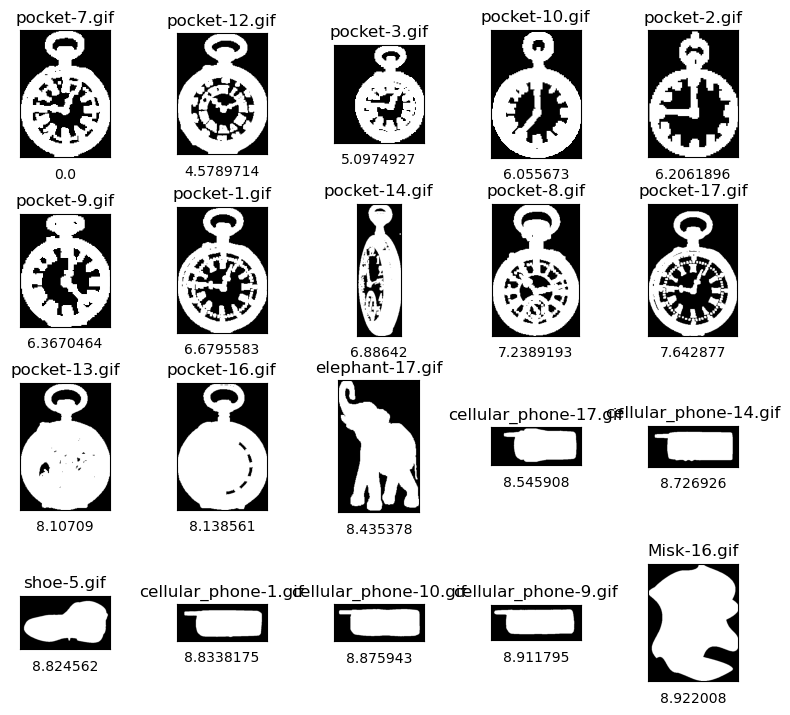

In [6]:
from utils import image_show

filenames = [dist['filename'] for dist in dist_index]
distances = [dist['distance'] for dist in dist_index]
images = []

for dist in dist_index[0: 20]:
    with Image.open(f"images/{dist['filename']}") as img:
        img = np.array(img, dtype=bool)
        images.append(img)
        
image_show(images, titles=filenames, labels=distances)